
# Stock Market Data

In this kernel, we will design and train the model we will use in our web app. We will develop a Long Short-Term Memory (LSTM) Neural Network and harness its capability to solve problems in time series. This model will take as input Closing Stock Prices of previous days and predict the next days Stock Prices.

Most resources online showed how to train a LSTM model on a single company's historical stock market dataset. Yet I want a model I can use to predict prices for various companies on the Alfred web-app. So I will aggregate a lot of data on publicly traded companies and train a model that can capture live stock market patterns.

In [84]:
import yfinance as yf

import pandas as pd
import numpy as np

import datetime
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, HoverTool
from bokeh.plotting import figure, output_notebook, show, save

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow.keras.backend as K

In [2]:
np.random.seed(512)


# Pre-Processing

In [3]:
# Get the same list of companies that can be studied on Alfred
companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S'
                         '%26P_500_companies')[0]
# For the sake of the Proof Of Concept, we will use fewer companies than that
companies = companies[['Symbol']][companies['GICS Sector'] == 'Information Technology'].values.flatten()

In [4]:
# Select a random company for evaluation
index = int(np.random.random()*len(companies))
eval_company = companies[index]
companies = np.delete(companies, index)
eval_company

'AAPL'

The first challenge posed to us is to format the data. The LSTM needs a window of historical data points and a window of target points. This function splits the data accordingly

In [5]:
# Shape the data into strips of historical prices for the LSTM
input_len = 30
output_len = 5

def split_data_prices_in_windows(df):
    """
    Create series of "input_len" Closing prices (X) and its coresponding "output_len" price (Y).  
    """
    LSTM_inputs = []
    LSTM_outputs = []
    for i in range(input_len, len(df)):
        # Process the model's input sequence
        historical_prices = df[i-input_len : i].copy()
        LSTM_inputs.append(np.array(historical_prices))
        
        # Process the model's expected output sequence
        target_price = df[i].copy()        
        LSTM_outputs.append(np.array(target_price))
        
    LSTM_inputs = np.array(LSTM_inputs)
    LSTM_outputs = np.array(LSTM_outputs)
    
    return LSTM_inputs, LSTM_outputs

Let's download all this data and store it in an array.

In [6]:
# We will manually create the arrays with the first company before looping for the rest
cmp = yf.download(companies[0])
# Get the closing price into a train and test array
train_set = cmp.iloc[:int(cmp.shape[0]*.80), 3:4].values
test_set = cmp.iloc[int(cmp.shape[0]*.80):, 3:4].values
# Get the closing price into format acceptable for the LSTM
x_train, y_train = split_data_prices_in_windows(train_set)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test, y_test = split_data_prices_in_windows(test_set)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

for company in companies[1:]:
    cmp = yf.download(company)
    # Get the closing price into a train and test array
    train_set_tmp = cmp.iloc[:int(cmp.shape[0]*.80), 3:4].values
    test_set_tmp = cmp.iloc[int(cmp.shape[0]*.80):, 3:4].values
    # Get the closing price into format acceptable for the LSTM
    x_train_tmp, y_train_tmp = split_data_prices_in_windows(train_set)
    x_train_tmp = np.reshape(x_train_tmp, (x_train_tmp.shape[0], x_train_tmp.shape[1]))
    x_test_tmp, y_test_tmp = split_data_prices_in_windows(test_set)
    x_test_tmp = np.reshape(x_test_tmp, (x_test_tmp.shape[0], x_test_tmp.shape[1]))
    # Gather the data points into a single array
    x_train = np.concatenate((x_train, x_train_tmp))
    x_test = np.concatenate((x_test, x_test_tmp))
    y_train = np.concatenate((y_train, y_train_tmp))
    y_test = np.concatenate((y_test, y_test_tmp))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Now that we have numerous company's historical stock market data, let us process it to facilitate the learning of the LSTM. Given the different scales of the companies, their stocks have different values. Let's scale the data according to the MinMaxScaler: normalize the data between (0, 1) based on the the overall maximum and minimum prices of all companies.

In [7]:
# Scale the data
total_max = x_train.max()
total_min = x_train.min()

x_train = (x_train - total_min) / (total_max - total_min)
x_test = (x_test - total_min) / (total_max - total_min)
y_train = (y_train - total_min) / (total_max - total_min)
y_test = (y_test - total_min) / (total_max - total_min)

In [85]:
# Save scaler information to inverse transform data in the web app
model_data = {
    'total_max' : total_max,
    'total_min' : total_min,
}

with open('data_win.txt', 'w') as outfile:
    json.dump(model_data, outfile)

In [8]:
# Shuffle the train data to avoid bias due to the ordering of data.
x_train, y_train = shuffle(x_train, y_train)

In [9]:
# Reshape the data for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Model Design

In [10]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
        
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [11]:
class LossHistory(Callback):
    def __init__(self):
        self.loss = []
        self.val_loss = []

    def on_batch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('val_loss'))

In [12]:
def LSTM_model(input_shape, output_shape, neurons, dropout):
    x = Input(shape=input_shape)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=False)(hidden)
    hidden = Dropout(dropout)(hidden)
    y = Dense(output_shape, activation='linear')(hidden)
    return Model(inputs=x, outputs=y)

model = LSTM_model((input_len, 1), output_len, 50, 0.2)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(optimizer=optimizer, metrics=['mse'], loss = 'mean_squared_error')

In [13]:
# Baseline
model.evaluate(x_test, y_test)

2055/2055 [==============================] - 16s 8ms/step - loss: 2.0945 - mse: 2.0945


[2.094503164291382, 2.094503164291382]

In [14]:
epoch_size = 100
batch_size = 32

# Create the Learning Rate Scheduler Callback
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length= 3,
                         mult_factor=1.5)

# Callback function to graph losses
lh = LossHistory()

# Callback function to stopp when the validation loss stagnates
es = EarlyStopping(patience=5)

# Training

In [15]:
model.fit(x_train, y_train, validation_data = (x_test, y_test),
          epochs = epoch_size, batch_size = batch_size, callbacks=[lh, schedule, es])

Epoch 1/100
8618/8618 [==============================] - 283s 33ms/step - loss: 8.6850e-04 - mse: 8.6850e-04 - val_loss: 0.0876 - val_mse: 0.0876
Epoch 2/100
8618/8618 [==============================] - 282s 33ms/step - loss: 5.5591e-04 - mse: 5.5591e-04 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 3/100
8618/8618 [==============================] - 282s 33ms/step - loss: 5.0362e-04 - mse: 5.0362e-04 - val_loss: 0.2006 - val_mse: 0.2006
Epoch 4/100
8618/8618 [==============================] - 276s 32ms/step - loss: 4.7310e-04 - mse: 4.7310e-04 - val_loss: 0.3215 - val_mse: 0.3215
Epoch 5/100
8618/8618 [==============================] - 275s 32ms/step - loss: 4.6211e-04 - mse: 4.6211e-04 - val_loss: 0.2823 - val_mse: 0.2823
Epoch 6/100
8618/8618 [==============================] - 275s 32ms/step - loss: 4.4895e-04 - mse: 4.4895e-04 - val_loss: 0.4704 - val_mse: 0.4704


In [16]:
# Save the model.
# serialize model to JSON
model_json = model.to_json()
with open("checkpoints/lstm_next_price_win_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("checkpoints/lstm_next_prices_win.h5")

# Evaluation

In [17]:
model.evaluate(x_test, y_test)

2055/2055 [==============================] - 16s 8ms/step - loss: 0.2006 - mse: 0.2006


[0.2005816102027893, 0.2005816102027893]

Text(0.5, 0, 'Epoch')

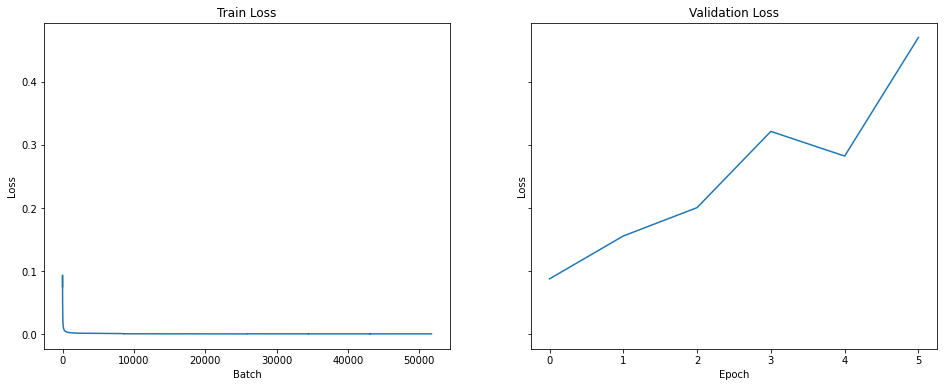

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.plot(lh.loss)
ax1.set_title('Train Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch')
ax2.plot(lh.val_loss)
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

## Evaluate on unseen stock

In [19]:
df = yf.download(eval_company)
df.index.name = None
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100266,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095035,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088059,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090239,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092855,73449600
...,...,...,...,...,...,...
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300
2020-11-10,115.550003,117.589996,114.129997,115.970001,115.970001,138023400
2020-11-11,117.190002,119.629997,116.440002,119.489998,119.489998,112295000
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300


In [20]:
eval_set = df.iloc[:, 3:4].values

x_eval, y_eval = split_data_prices_in_windows(eval_set)
x_eval = np.reshape(x_eval, (x_eval.shape[0], x_eval.shape[1]))

x_eval = (x_eval - total_min) / (total_max - total_min)
y_eval = (y_eval - total_min) / (total_max - total_min)
x_eval = np.reshape(x_eval, (x_eval.shape[0], x_eval.shape[1], 1))

In [21]:
predicted_stock_price = model.predict(x_eval)
# Transform the predicted data back to stock prices
predicted_stock_price = predicted_stock_price * (total_max - total_min) + total_min

In [81]:
df1 = pd.DataFrame(eval_set, index=df.iloc[:, 3:4].index, columns=["Close"])
df1["Date"] = pd.to_datetime(df1.index)
dates1 = df1['Date']
source1 = ColumnDataSource(data=dict(date=dates1, close=df1['Close']))

p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates1[dates1.index[-100]], dates1[dates1.index[-1]]))
tmp = p.x_range # Store it before adding multiple lines
p.line('date', 'close', source=source1, legend_label='Real Stock Price', color='green')

for i, y_pred in enumerate(predicted_stock_price[::output_len]):
    if df1.iloc[input_len+output_len*(i):input_len+output_len*(i+1)].index.shape[0] != output_len:
        continue
    df2 = pd.DataFrame(y_pred,
                       index=df1.iloc[input_len+output_len*(i):input_len+output_len*(i+1)].index,
                       columns=["Close"])
    df2["Date"] = pd.to_datetime(df2.index)
    source2 = ColumnDataSource(data=dict(date=df2['Date'], close=df2['Close']))
    p.line('date', 'close', source=source2, legend_label='Predicted Stock Price', color='red')

p.yaxis.axis_label = 'Price'

hover_tool = HoverTool(
    tooltips=[
        ( 'date',   '@date{%F}'            ),
        ( 'close',  '$@{close}{%0.2f}' ), # use @{ } for field names with spaces
    ],

    formatters={
        '@date'        : 'datetime', # use 'datetime' formatter for '@date' field
        '@{close}' : 'printf',   # use 'printf' formatter for '@{adj close}' field
                                     # use default 'numeral' formatter for other fields
    },

    # display a tooltip whenever the cursor is vertically in line with a glyph
    # mode='vline'
)
p.add_tools(hover_tool)

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range, tools=TOOLS, 
                x_axis_type="datetime", y_axis_type=None,
                toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=tmp)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source1)
select.ygrid.grid_line_color = None
select.add_tools(range_tool, hover_tool)
select.toolbar.active_multi = range_tool

# output_notebook()
# show(column(p, select))
save(column(p, select), filename="plots/lstm_next_price_win.html")

/home/fournierp/.local/share/virtualenvs/alfred-Mlefol6Z/lib/python3.8/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/fournierp/.local/share/virtualenvs/alfred-Mlefol6Z/lib/python3.8/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/fournierp/Documents/alfred/models/plots/lstm_next_price_win.html'